
<a id='chap-tpcvae'></a>

# Travaux pratiques : VAE conditionnel et PixelCNN

L’objectif de cette séance de travaux pratiques est d’utiliser d’une
part la génération conditionnée de chiffres à l’aide d’un autoencoder
variationnel conditionnel et d’autre part d’illustrer la mise en œuvre
d’un modèle autorégressif sur des images, en l’occurrence PixelCNN.

## Préambule

Comme les semaines passées, nous pouvons commencer par importer quelques
bibliothèques utiles (Matplotlib, NumPy et PyTorch).

In [1]:
# Import des bibliothèques utiles
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Il est préférable d’utiliser une machine dotée d’une carte graphique
(GPU) pour ce TP afin d’accélérer les calculs et ne de pas devoir
patienter trop longtemps lors de l’entraînement des modèles.

In [2]:
# Utilise la carte graphique (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VAE conditionnel

Pour commencer, nous allons implémenter un autoencodeur variationnel
conditionnel en nous inspirant du VAE que nous avons écrit lors du
précédent TP. À titre d’illustration, nous allons expérimenter avec la
base de données MNIST qui contient des chiffres manuscrits étiquetés de
0 à 9.

In [3]:
from torchvision.transforms import ToTensor, ToPILImage

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.67MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 221kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 767kB/s]


On souhaite dans notre cas conditionner le modèle au chiffre représenté
par l’image. Cette information correspond dans le jeu de données à une
étiquette sous la forme d’un entier de 0 à 9, que l’on représentera plus
tard sous la forme d’un vecteur en encodage *one-hot*, c’est-à-dire :
`[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]` pour l’étiquette $ 6 $.

La longueur du vecteur de conditionnement est donc 10 (le nombre de
classes du jeu de données).

In [4]:
num_classes = 10

## Question

Reprendre le code du VAE du TP précédent et l’adapter de sorte à ce que
:

- l’encodeur accepte le vecteur de conditionnement comme deuxième
  argument dans la méthode `.forward()`. Il faudra notamment décider
  de l’endroit où injecter le vecteur de conditionnement (on pourra,
  par exemple, le concaténer au vecteur aplati des *features* obtenu en
  sortie des couches convolutives).  
- le décodeur accepte le vecteur de conditionnement comme deuxième
  argument dans la méthode `.forward()`. On se contentera de
  concaténer le conditionnement au code latent `z`.  


Attention, il ne faut pas oublier de modifier les dimensions des couches
entièrement connectées lorsque cela est nécessaire. En effet, l’espace
latent « change » de dimension lorsque que l’on concatène le vecteur de
conditionnement au code latent…

**Indice** : la méthode `torch.cat()` et sa
[documentation](https://pytorch.org/docs/stable/generated/torch.cat.html)
pourront vous être utiles.

## Correction

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                   )
        self.linear1 = nn.Linear(in_features=64*7*7+num_classes, out_features=latent_dimension)
        self.linear2 = nn.Linear(in_features=64*7*7+num_classes, out_features=latent_dimension)

    def forward(self, x, c):
        x = self.model(x)
        x = torch.cat((x, c), dim=1)
        x_mu = self.linear1(x)
        x_logvar = self.linear2(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=latent_dimension+num_classes, out_features=64*7*7)
        self.model = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
                                     nn.Sigmoid(),
                                    )

    def forward(self, z, c):
        z = torch.cat((z, c), dim=1)
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.model(hat_x)
        return hat_x

## Question

De la même façon, modifier l’implémentation de l’autoencodeur variationnel.

## Correction

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x, c):
        latent_mu, latent_logvar = self.encoder(x, c)
        z = self.latent_sample(latent_mu, latent_logvar)
        hat_x = self.decoder(z, c)
        return hat_x, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

La boucle d’apprentissage ne change presque pas par rapport au TP
précédent : il suffit d’encoder les étiquettes dans le format *one-hot*
et de les fournir au VAE au moment du calcul de la reconstruction.

In [7]:
from tqdm.notebook import trange, tqdm

def vae_loss(hat_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=32, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = vae_loss
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, labels in tqdm(train_dataloader):
            images = images.to(device)
            # Encodage one-hot des labels
            labels = F.one_hot(labels, num_classes=10).to(device)

            # Calcul de la reconstruction
            reconstructions, latent_mu, latent_logvar = net(images, labels)
            # Calcul de l'erreur
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu").eval()

Nous pouvons ainsi entraîner notre VAE conditionnel sur la base de
données MNIST :

In [8]:
vae = VariationalAutoencoder(10)
vae = train_vae(vae, train_dataset)

Entraînement du modèle:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

## Question

Générer et visualiser des chiffres de différentes classes en
échantillonnant dans la distribution conditionnelle. Le code latent est
toujours échantillonné selon une loi normale
$ \mathcal{N}(0, \mathbf{I}) $, seul le vecteur de conditionnement
change.

## Correction

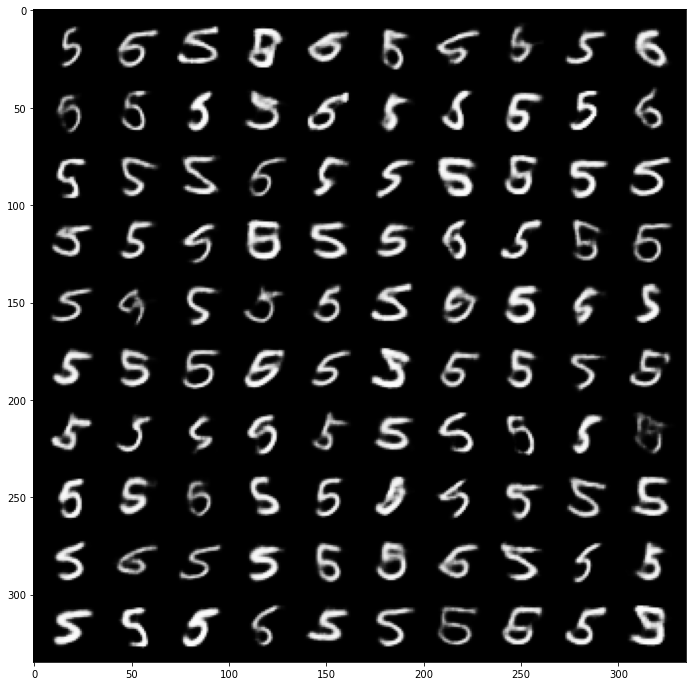

In [9]:
def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

vae.eval()
digit = 5

with torch.no_grad():

    # Échantillonnage selon une loi normale
    latent = torch.randn(100, 10)
    # Conditionnement
    condition = torch.zeros(100, 10, dtype=int)
    condition[:, digit] = 1

    # Reconstruction
    fake_images = vae.decoder(latent, condition).cpu()

    fig, ax = plt.subplots(figsize=(12,12))
    show_grid(torchvision.utils.make_grid(fake_images.data[:100],10,5))
    plt.show()

## PixelCNN

## Note

Cet exercice est un approfondissement optionnel.

[PixelCNN](https://arxiv.org/abs/1601.06759) est un modèle
autorégressif permettant d’estimer la densité d’un jeu de données
d’images. La différence essentielle entre PixelCNN et un CNN
traditionnel est l’application de masques sur les noyaux de convolution.
Ceux-ci permettent de cacher l’information des pixels non encore
rencontrés par le modèle afin de ne pas briser le processus
autorégressif :

$$
p(\mathbf{x}) = \prod_{i=1}^{n^2} p(x_i|x_1, \dots, x_{i-1})
$$

Dans l’article de PixelCNN, deux types de masques sont introduits :

- les masques de type `'A'` ne perçoivent que le quart nord-ouest du
  noyau de convolution sans le pixel central,  
- les masques de type `'B'` perçoivent égalemment le pixel central.  


En pratique, la première couche de convolution masquée est de type A
tandis que les couches suivantes sont de type B.

## Question

Expliquer brièvement l’intérêt du masque de type A et pourquoi il est nécessaire que la première couche du modèle soit de ce type.

Pour cet exemple, nous allons utiliser le jeu de données FashionMNIST
(mais vous pouvez conserver le jeu de données MNIST si vous préférez, ce
dernier étant d’ailleurs plus facile à modéliser).

In [10]:
from torchvision.transforms import ToTensor, ToPILImage

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST


train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

Les convolutions masquées de type A et B n’existent pas nativement dans
PyTorch, il est donc nécessaire que nous les implémentions par
nous-mêmes. Nous allons définir un nouveau module `MaskedConvolution`
qui hérite de la convolution 2D standard de PyTorch.

Dans une convolution 2D `nn.Conv2d`, les poids des filtres convolutifs
sont stockés dans l’attribut `.weight.data`. Nous allons donc
introduire un nouvel attribut `.weight.mask` de même dimensions que
les filtres de convolution mais qui contiendra des entrées binaires : 1
pour les pixels que l’on doit conserver, 0 pour les pixels que l’on doit
masquer.

<img src="images/pixelcnn_masque_a.png" alt="Masque de convolution de type A" style="">

Masque de convolution de type A  

## Question

Implémenter les nouveaux noyaux de convolution avec les masques correspondants.

## Correction

In [11]:
class MaskedConvolution(nn.Conv2d):

    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConvolution, self).__init__(*args, **kwargs)

        # Vérifier que le type de masque est autorisé
        assert mask_type in ['A', 'B'], "Type invalide"
        self.mask_type = mask_type

        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()

        # Poids de la convolution :
        # on débute avec des 1 partout (tous les pixels sont considérés)
        self.mask.fill_(1)

        if mask_type == 'A':
            self.mask[:,:, height//2 ,width//2:] = 0
            self.mask[:,:, height//2 + 1:,:] = 0
        elif mask_type == 'B':
            self.mask[:,:, height//2, width//2 + 1:] = 0
            self.mask[:,:, height//2 + 1:,:] = 0


    def forward(self, x):
        # Le filtre convolutif est "masqué" par multiplication avec le masque binaire
        self.weight.data *= self.mask
        return super(MaskedConvolution, self).forward(x)

Le modèle PixelCNN que nous allons implémenter s’inspire fortement de
celui qui est décrit dans l’article original. Il s’agit d’un simple
enchaînement de convolutions (masquées), de *BatchNorm* et d’activations
non-linéaires (*ReLU*). En réalité, la seule différence avec un CNN
habituel est l’utilisation du module `MaskedConvolution` à la place
des couches `nn.Conv2d` classiques.

On considèrera que les images en niveaux de gris (valeurs entre 0 et
255) correspondent à des images de 256 classes. En sortie, nous aurons
donc une prédiction par pixel, chaque prédiction correspondant à un
vecteur de logits (avant *softmax*) de 256 valeurs. La sortie est donc
une carte d’activations $ (28\times 28 \times 256) $ (avec les mêmes
dimensions spatiales que l’image d’entrée, puisque l’on prédit la valeur
de chaque pixel).

## Question

Implémenter le modèle suivant:

- Convolution masquée de type A (1 canal d’entrée, `channels` canaux
  de sortie, noyau de dimension 7, `stride=1`, `padding=3`) +
  *BatchNorm* + *ReLu*  
- Convolution masquée de type B (`channels` canaux d’entrée,
  `channels` canaux de sortie, noyau de dimension 3, `stride=1`,
  `padding=1`) + *BatchNorm* + *ReLU*  
  - à répéter **7 fois**  
- Convolution classique (`channels` canaux d’entrée, `classes`
  canaux de sortie, `kernel_size=1` (pour mettre la sortie dans la
  bonne dimension)  

## Correction

In [12]:
class PixelCNN(nn.Module):
    """
    PixelCNN implémenté dans l'esprit de van den Oord et al., 2016 (https://arxiv.org/abs/1601.06759)
    """
    def __init__(self, classes=256, channels=64):
        super(PixelCNN, self).__init__()

        def conv_block(mask_type, in_channels, out_channels, kernel):
            return nn.Sequential(
                MaskedConvolution(mask_type, in_channels, out_channels, kernel_size=kernel, stride=1, padding=kernel//2, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
        )


        self.conv_block1 = conv_block('A', 1, channels, 7)

        self.conv_block2 = conv_block('B', channels, channels, 3)
        self.conv_block3 = conv_block('B', channels, channels, 3)
        self.conv_block4 = conv_block('B', channels, channels, 3)
        self.conv_block5 = conv_block('B', channels, channels, 3)
        self.conv_block6 = conv_block('B', channels, channels, 3)
        self.conv_block7 = conv_block('B', channels, channels, 3)
        self.conv_block8 = conv_block('B', channels, channels, 3)

        self.out = nn.Conv2d(channels, classes, kernel_size=1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.conv_block7(x)
        x = self.conv_block8(x)
        return self.out(x)

A présent nous allons entraîner ce modèle sur FashionMNIST. Comme nous
considérons que la distribution est pixels est discrète, la fonction de
coût est l’entropie croisée, comme d’habitude lorsque nous avons affaire
à une tâche de classification. À noter que dans notre cas, l’entropie
croisée est moyennée sur les prédictions pour tous les pixels de l’image
autorégressée.

In [13]:
from tqdm.notebook import trange, tqdm

def train(net, train_dataset, epochs=5, learning_rate=1e-3, batch_size=32, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
    # Choix de la fonction de coût (entropie croisée)
    criterion = nn.CrossEntropyLoss()
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, _ in tqdm(train_dataloader):
            # les labels sont ignorés pour l'apprentissage de l'auto-encodeur

            images = images.to(device)
            # Conversion en 256 classes
            target = (images[:,0]*255).long().to(device)

            # Calcul de la reconstruction
            reconstructions = net(images)
            # Calcul de l'erreur
            loss = F.cross_entropy(reconstructions, target)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()
            t.set_description(f"Epoch {epoch}: loss = {loss.item():.3f}")

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.eval()

In [ ]:
net = PixelCNN()
net = train(net, train_dataset)

## Question

Calculer et visualiser les reconstructions de quelques exemples du jeu de test.

## Correction

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
images, labels = iter(test_dataloader).next()

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = torch.argmax(images,dim=1).unsqueeze(dim=1)/255
        images = to_img(images)
        print(images.shape)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()
# First visualise the original images
print('Original images')
plt.figure(figsize=(12, 6))
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
plt.figure(figsize=(12, 6))
visualise_output(images, net)

Ce modèle PixelCNN peut être utilisé pour générer séquentiellement des
images synthétiques respectant les probabilités conditionnelles
apprises. Pour ce faire, il est nécessaire de partir d’une image vide
(contenant uniquement des zéros) puis d’inférer le premier pixel, et
ainsi de suite.

On peut compléter de cette façon l’image colonne par colonne puis ligne
par ligne en utilisant le modèle afin de prédire la valeur du pixel
suivant (c’est-à-dire la probabilité suivante du processus
autorégressif).

## Question

Parcourir l’image synthétique pour la remplir pixel par pixel. Il sera
nécessaire d’effectuer une inférence à chaque ajout d’un nouveau pixel.
Les probabilités des classes (c’est-à-dire la valeur du pixel de 0 à
255) sera obtenue en appliquant une activation *softmax* sur les scores
bruts en sortie du modèle. Cela permettra d’obtenir la distribution
multinomiale dans laquelle échantillonner la valeur du pixel suivant.

Il est également possible de choisir systématiquement la classe la plus
probable mais ce procédé déterministe ne permettra de générer qu’une
seule image (toujours la même).

## Correction

In [ ]:
sample = torch.zeros((128, 1, 28, 28)).to(device)

net.eval()
for i in range(28):
    for j in range(28):
        out = net(sample)
        probs = F.softmax(out[:, :, i, j],dim=1).data
        sample[:, :, i, j] = torch.multinomial(probs, 1).float() / 255.

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
show_image(torchvision.utils.make_grid(sample.cpu().data[:100],10,5))
plt.show()